 # Notebook para detecção de quebra de diálogo

In [23]:
#imports
from os.path import join as pathjoin;
from os import listdir;
import os;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy
import sklearn.pipeline

## Bases de desenvolvimento

In [5]:
base_path = 'C:/Users/landrade/Dropbox/python/dbdc3/'
#base_path = 'C:/Users/Leonardo de Andrade/Dropbox/python/dbdc3/'
dev_data_path = pathjoin(base_path,'data/dbdc3/en/dev/')
eval_data_path = pathjoin(base_path,'data/dbdc3/en/eval/')

cic_dev_path = pathjoin(dev_data_path,'CIC_115/')
iris_dev_path = pathjoin(dev_data_path,'IRIS_100/')
tktk_dev_path = pathjoin(dev_data_path,'TKTK_100/')
yi_dev_path = pathjoin(dev_data_path,'YI_100/')

cic_eval_path = pathjoin(eval_data_path,'CIC_34/')
iris_eval_path = pathjoin(eval_data_path,'IRIS_30/')
tktk_eval_path = pathjoin(eval_data_path,'TKTK_30/')
yi_eval_path = pathjoin(eval_data_path,'YI_30/')

In [6]:
def separateEval(originPath, destinationPath, count):
    files = listdir(originPath)
    eval_files = numpy.random.choice(files,count,False)
    if not os.path.exists(destinationPath):
        os.makedirs(destinationPath)
    for file in eval_files:
        os.rename(pathjoin(originPath,file),pathjoin(destinationPath,file))

## Separando 30% em arquivos de teste

In [43]:
# Comentando para não correr o risco de rodar novamente
#separateEval(cic_dev_path,cic_eval_path,34)
#separateEval(iris_dev_path,iris_eval_path,30)
#separateEval(tktk_dev_path,tktk_eval_path,30)
#separateEval(yi_dev_path,yi_eval_path,30)

### Funções úteis

In [7]:
def loadConversations(path):
    conversations = []
    for f in listdir(path):
        if '.log.json' in f:
            json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
            json_obj['file_name'] = f
            conversations.append(json_obj)
    return conversations

In [11]:
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations
        

In [8]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [9]:
def printHistogram(data,name):
    print('O = not a breakdown, T = possible breakdown, and X = breakdown')
    dataSum = ConversationClassCount(data)
    plt.hist(list(dataSum.keys()), weights=list(dataSum.values()))
    plt.title(name)
    plt.show()

### Computando distribuição e voto majoritário

In [13]:
cic_data = SetMajorityVoteAndDistribution(loadConversations(cic_dev_path),0)
iris_data = SetMajorityVoteAndDistribution(loadConversations(iris_dev_path),0)
tktk_data = SetMajorityVoteAndDistribution(loadConversations(tktk_dev_path),0)
yi_data = SetMajorityVoteAndDistribution(loadConversations(yi_dev_path),0)

cic_eval = SetMajorityVoteAndDistribution(loadConversations(cic_eval_path),0)
iris_eval = SetMajorityVoteAndDistribution(loadConversations(iris_eval_path),0)
tktk_eval = SetMajorityVoteAndDistribution(loadConversations(tktk_eval_path),0)
yi_eval = SetMajorityVoteAndDistribution(loadConversations(yi_eval_path),0)

O = not a breakdown, T = possible breakdown, and X = breakdown


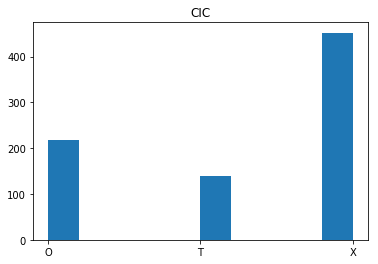

O = not a breakdown, T = possible breakdown, and X = breakdown


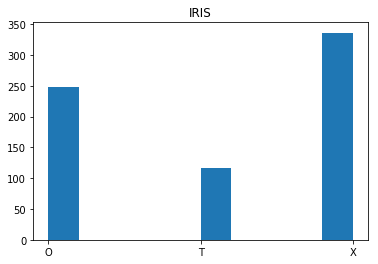

O = not a breakdown, T = possible breakdown, and X = breakdown


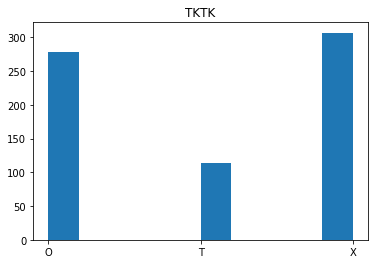

O = not a breakdown, T = possible breakdown, and X = breakdown


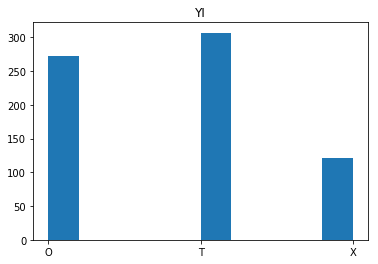

In [81]:
printHistogram(cic_data,'CIC')
printHistogram(iris_data,'IRIS')
printHistogram(tktk_data,'TKTK')
printHistogram(yi_data,'YI')

In [14]:
def PrepareDataSet(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        if c['turns'][0]['speaker']=='S':
            del c['turns'][0]
        turns_len = len(c['turns'])
        for i in range(0,turns_len,2):
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = c['turns'][i]['utterance']
                line['system-index'] = c['turns'][i+1]['turn-index']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [16]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def _init_(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [17]:
import numpy as np
class ArrayCaster(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    return self

  def transform(self, data):
    return np.transpose(np.matrix(data))

## Monta o dataset

In [18]:
train = pd.DataFrame(PrepareDataSet(cic_data))
train = train.append(pd.DataFrame(PrepareDataSet(iris_data)))
train = train.append(pd.DataFrame(PrepareDataSet(tktk_data)))
train = train.append(pd.DataFrame(PrepareDataSet(yi_data)))

test = pd.DataFrame(PrepareDataSet(cic_eval))
test = test.append(pd.DataFrame(PrepareDataSet(iris_eval)))
test = test.append(pd.DataFrame(PrepareDataSet(tktk_eval)))
test = test.append(pd.DataFrame(PrepareDataSet(yi_eval)))

In [96]:
train

,O,T,X,class,dialogue-id,file_name,system-index,system-utterance,user-index,user-utterance
0,0.166667,0.333333,0.500000,X,CIC0003,CIC0003.log.json,2,Thank you.,1,Hi! Wow! Nice introductionWhat is the text about?
1,0.266667,0.333333,0.400000,X,CIC0003,CIC0003.log.json,4,I don't know.,3,What is the text about?
2,0.133333,0.333333,0.533333,X,CIC0003,CIC0003.log.json,6,I don't know.,5,But you said that you are professional...
3,0.100000,0.233333,0.666667,X,CIC0003,CIC0003.log.json,8,Yes.,7,Okay
4,0.133333,0.333333,0.533333,X,CIC0003,CIC0003.log.json,10,Okay.,9,Is hunting requeres an license?
5,0.100000,0.233333,0.666667,X,CIC0003,CIC0003.log.json,12,"No, no, no, no, no, no, no, no, no.",11,Is hunting requires an license?
6,0.066667,0.200000,0.733333,X,CIC0003,CIC0003.log.json,14,"No, no, no, no, no, no, no, no, no.",13,Take it easySome states make a distinction bet...
7,0.133333,0.300000,0.566667,X,CIC0003,CIC0003.log.json,16,Don't worry about it,15,Some states make a distinction between protect...
8,0.233333,0.300000,0.466667,X,CIC0003,CIC0003.log.json,18,species and unprotected speciesI don't know.sp...,17,okaygood bye
9,0.166667,0.500000,0.333333,T,CIC0003,CIC0003.log.json,20,Okay.,19,"yeah, you are right!"


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=2,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=2,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
            
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0
        },
    )),

    # Use a SVC classifier on the combined features
    ('svc', SVC(kernel='linear')),
])

In [20]:
pipeline.fit(train, train['class'])

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user-utterance', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key='user-utterance')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [90]:
y = pipeline.predict(test)
print(classification_report(y, test['class']))

             precision    recall  f1-score   support

          O       0.59      0.58      0.59       437
          T       0.30      0.42      0.35       214
          X       0.65      0.56      0.60       589

avg / total       0.57      0.54      0.55      1240



In [37]:
from sklearn.feature_extraction.text import CountVectorizer
x =CountVectorizer().fit_transform(train['user-utterance'])

In [81]:
x =CountVectorizer().fit_transform(['eu amo','eu amo paçoca','eu amo paçoca'])>0

(array([0., 0., 0., 0., 0., 4., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

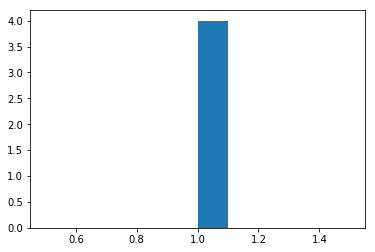

In [100]:
plt.hist( (  CountVectorizer().fit_transform(['eu','eu','eu','eu'])  ).sum(axis=1))

In [92]:
print(x)
print(x.todense())

  (0, 0)	True
  (0, 1)	True
  (1, 0)	True
  (1, 1)	True
  (1, 2)	True
  (2, 0)	True
  (2, 1)	True
  (2, 2)	True
[[ True  True False]
 [ True  True  True]
 [ True  True  True]]


(array([725., 903., 629., 470., 103.,  45.,  24.,   8.,   1.,   2.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

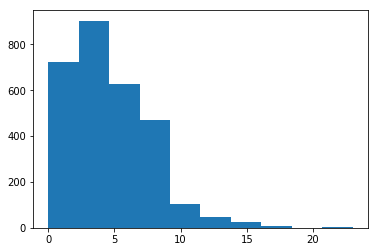

In [35]:
plt.hist( (  CountVectorizer().fit_transform(train['user-utterance']) >0 ).sum(axis=1))

(array([1513.,  778.,  414.,   99.,   55.,   30.,   10.,    5.,    3.,
           3.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

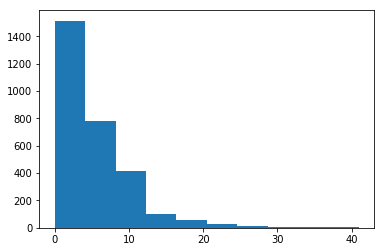

In [36]:
plt.hist( (  CountVectorizer().fit_transform(train['system-utterance']) >0 ).sum(axis=1))

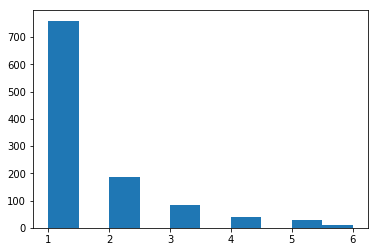

In [78]:
plt.hist(np.array(CountVectorizer(binary=True,max_df=6).fit_transform(train['user-utterance']).sum(axis=0))[0]);